In [1]:
from PIL import Image, ImageOps
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.linear_model import SGDClassifier

In [2]:
def aanmakenDf (groep, label):
#Drie lege lijsten worden aangemaakt die dan uiteindelijk samen dataframe zullen vormen 
    Pixels= []
    Label =[]
    # BDP: we hebben naam niet nodig om te trainen, enkel pixels en labels => verwijder
    Naam=[]
  
#fotos inlezen en omzetten per groep. 
    for foto in os.listdir(groep):
        beeld = Image.open(groep+foto)
#fotos omzetten in grijswaarde of 2 dimensionele array ipv 3x2
        beeld_grijs = ImageOps.grayscale(beeld)

#fotos resizen voor leesbaarheid tijdens testen, en eventueel voor latere experimenten
        beeld_formaat = beeld_grijs.resize((beeld_grijs.width // 1, beeld_grijs.height //1 ))       
        
#fotos omzetten naar numpy array
        data_2dim = np.asarray(beeld_formaat, dtype=np.uint8)
        data = data_2dim.flatten()

#3 lijsten opvullen, eerste met data van foto, tweede met label en derde met naam van foto. 
#De lengte van elke lijst = aantal fotos in bijhorende map
        Pixels.append(data)
        Label.append(label)
        Naam.append(foto)

#Per groep worden de drie aangemaakte lijsten omgezet naar panda df
# BDP: we hebben naam niet nodig om te trainen, enkel pixels en labels => verwijder

    dict = {'data': Pixels, 'label': Label, 'naam': Naam}
    df = pd.DataFrame(dict)
    return df

In [3]:
#Dataframe aanmaken
aanwezig = r"classificatie/aanwezig/"  #852 foto's 
buiten = r"classificatie/buiten/"       #389 foto's
niets = r"classificatie/niets/"         #1399 foto's
#Eerst wordt per map een panda dataframe aangemaakt
nietsDf = aanmakenDf(niets, 0)
aanwezigDf = aanmakenDf(aanwezig, 1)
buitenDf = aanmakenDf(buiten, 2)
#vervolgens worden ze alle drie samengevoegd tot 1 groot dataframe
volledigDataframe = pd.concat([nietsDf, aanwezigDf, buitenDf], ignore_index=True)

In [4]:
#Opsplitsen in gestratificieerde testset en trainingsset
# BDP: onderstaande lijn mag weg, seeding zit in StratifiedShuffleSplit
np.random.seed(42)
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(volledigDataframe, volledigDataframe['label']):
    strat_train_set = volledigDataframe.loc[train_index]
    strat_test_set = volledigDataframe.loc[test_index] 
#X = data, y = label. Dit voor trainingsset en testset
# BDP: we hebben naam niet nodig om te trainen, enkel pixels en labels => verwijder

X_train, X_test, y_train, y_test, naam_train, naam_test = strat_train_set['data'], strat_test_set['data'], strat_train_set['label'], strat_test_set['label'], strat_train_set['naam'], strat_test_set['naam']

In [5]:
#Omzetten naar np.array
X_train_array = np.array(X_train.tolist())
X_test_array = np.array(X_test.tolist())
y_train_array = np.array(y_train)
y_test_array = np.array(y_test)
# BDP: we hebben naam niet nodig om te trainen, enkel pixels en labels => verwijder

naam_train_array= np.array(naam_train)
naam_test_array= np.array(naam_test)

train a model

In [6]:
#RandomforestClassifier
from sklearn.ensemble import RandomForestClassifier
forest_clf = RandomForestClassifier(random_state=42)
forest_clf.fit(X_train_array, y_train_array)

RandomForestClassifier(random_state=42)

In [7]:
some_musti = X_train[0]
forest_clf.predict([some_musti])

array([0], dtype=int64)

result: 0

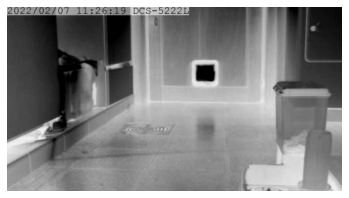

In [8]:
some_musti_image = some_musti.reshape(352, 640)
plt.imshow(some_musti_image, cmap=mpl.cm.binary)
plt.axis("off")

plt.show()

Evaluate this classifier

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(forest_clf, X_train_array, y_train_array, cv=3, scoring="accuracy")

array([0.94034091, 0.94744318, 0.93323864])

0: 0.940341
1: 0.947443
2: 0.933239

improve the result by scaling => to be removed, or explain why result isn't better

In [11]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_array.astype(np.float64))
cross_val_score(forest_clf, X_train_scaled, y_train_array, cv=3, scoring="accuracy")

array([0.94034091, 0.94886364, 0.93465909])

0: 0.94034091
1: 0.94886364
2: 0.93465909

do the same for sgd, svm and voting

In [12]:
# sgd
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
cross_val_score(sgd_clf, X_train_scaled, y_train_array, cv=3, scoring="accuracy")

array([0.91761364, 0.92897727, 0.91903409])

0: 0.917614
1: 0.928977
2: 0.919034

In [13]:
# svm
from sklearn.svm import SVC
svm_clf = SVC()
cross_val_score(svm_clf, X_train_scaled, y_train_array, cv=3, scoring="accuracy")

KeyboardInterrupt: 

SVM loopt zeer lang, afgebroken. SVM presteert slecht met grote datasets en met multiclass

add voting classifier

In [ ]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
log_clf = LogisticRegression(solver="lbfgs", random_state=42)
forest2_clf = RandomForestClassifier(n_estimators=100, random_state=42)
svm2_clf = SVC(gamma="scale", random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('rf', forest2_clf), ('svc', svm2_clf)],
    voting='hard')
cross_val_score(voting_clf, X_train_scaled, y_train_array, cv=3, scoring="accuracy")

niet uitgevoerd

select the best model and fine tune the parameters

In [14]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

# train across 5 folds, that's a total of (12+6)*5=90 rounds of training
grid_search = GridSearchCV(forest_clf, param_grid, cv=5,
                           scoring='accuracy',
                           return_train_score=True)
grid_search.fit(X_train_scaled, y_train_array)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='accuracy')

select the final model

In [15]:
final_model= grid_search.best_estimator_

get params to show

In [16]:
grid_search.best_params_

{'max_features': 8, 'n_estimators': 30}

save the final model

In [17]:
import joblib
joblib.dump(final_model, "models/final_model.pkl")
#...
#my_model_loaded = joblib.load("models/my_model.pkl")

['models/final_model.pkl']

ERROR ANALYSIS

In [18]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
y_train_pred = cross_val_predict(final_model, X_train_scaled, y_train_array, cv=3)
conf_mx = confusion_matrix(y_train_array, y_train_pred)
conf_mx

array([[1110,    9,    0],
       [  69,  585,   28],
       [   6,   40,  265]], dtype=int64)

realiteit niets, 9 voorspeld als binnen, 0 voorspeld als buiten
realiteit binnen, 69 voorspeld als niets, 28 voorspeld als buiten
realiteit buiten, 6 voorspeld als niets, 40 voorspeld als binnen

convert this into an image

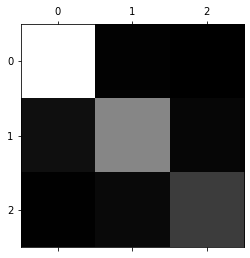

In [19]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

improve image for error analysis

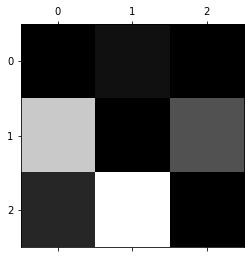

In [20]:
row_sums = conf_mx.sum(axis=1, keepdims=True)  # returns a 1-dimensional array with row totals
norm_conf_mx = conf_mx / row_sums
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

grootste probleem: realiteit buiten, maar voorspeld als binnen
2de probleem: realiteit binnen, maar voorspeld als niets
3de probleem: realiteit binnen, maar voorspeld als buiten
4de probleem: realiteit niets, maar voorspeld als binnen

ACCURACY

In [27]:
from sklearn.metrics import accuracy_score
accuracy_score(y_train_array, y_train_pred)

0.928030303030303

The model makes predictions with an accuracy of 92.8%, we can use that as threshold

calculate precision and recall and decide which threshold to use

In [22]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_array, y_train_pred, average=None)

array([0.93670886, 0.92271293, 0.90443686])

average=None: parameter required for multiclass, if None, the scores for each class are returned
94% of all predicted 'niets' are truly 'niets'
92% of all predicted 'binnen' are truly 'binnen'
90% of all predicted 'buiten' are truly 'buiten'

precision: percent van echte voorspelde niet aanwezig, binnen of buiten tov. van alle voorspelde niet aanwezig, binnen of buiten

In [23]:
recall_score(y_train_array, y_train_pred, average=None)

array([0.9919571 , 0.85777126, 0.85209003])

99% van echte niets ook effectief als niets voorspeld
86% van echte binnen ook effectief als binnen voorspeld
85% van echte buiten ook effectief als buiten voorspeld

recall: percent van echte voorspelde niet aanwezig, binnen of buiten tov. van alle echte niet aanwezig, binnen of buiten

In [24]:
from sklearn.metrics import f1_score

f1_score(y_train_array, y_train_pred, average=None)

array([0.96354167, 0.88905775, 0.87748344])

decide which threshold to use

In [25]:
#y_scores = cross_val_predict(final_model, X_train_scaled, y_train, cv=3, method='decision_function')
# the random forest classifier does not have a decision_function. Instead a predict_proba
y_probas = cross_val_predict(final_model, X_train_scaled, y_train_array, cv=3, method='predict_proba')
y_scores = y_probas[:,1]

balanced_accuracy_score

In [28]:
from sklearn.metrics import balanced_accuracy_score
balanced_accuracy_score(y_train_array, y_train_pred)

0.900606132569683

actually we should use ROC since the positive class is not rare, and we don't care more for false positives than false negatives

roc auc score

In [31]:
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_train_array,y_scores, average=None, multi_class='ovr'))

AxisError: axis 1 is out of bounds for array of dimension 1